In [239]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import autograd.numpy as np
from autograd import grad, jacobian
from scipy import optimize as opt
# import numba
from functools import lru_cache
import warnings
import seaborn as sns
sns.set(
    style='ticks'
)

from rakott.mpl import savefig_bbox, fig_panel_labels

In [2]:
W = 1.0
w = 0.1
ρ = 0.5
P = 0.2

In [3]:
def f1(x, wA, wB, ρ, dx=0):    
    wbar = x * wA + (1 - x) * wB
    x = ρ * x * wA/wbar + (1 - ρ) * x
    if dx > 0:
        x += dx * np.sign(wB - wA)
    return x
# nf1 = numba.jit(f1)
df1 = grad(f1)

x = 0.25
print('f1(0.25) =', f1(0.25, W, w, ρ))
print('df1(0.25) =', df1(0.25, W, w, ρ))

dx = 1e-4
assert np.isclose(f1(x + dx, W, w, ρ, dx=1e-10), f1(x, W, w, ρ, dx=1e-10) + df1(x, W, w, ρ, dx=1e-10) * dx)

f1(0.25) = 0.5096153846153846
df1(0.25) = 0.973372781065


In [ ]:
%timeit f1(x, W, w, ρ)
%timeit nf1(x, W, w, ρ)
%timeit df1(x, W, w, ρ)

In [4]:
def F1(x, W, w, ρ, k, l, dx=0): 
    for _ in range(k):
        x = f1(x, W, w, ρ, dx=dx)
    for _ in range(l):
        x = f1(x, w, W, ρ, dx=dx)
    return x
# nF1 = numba.jit(F1)
dF1 = jacobian(F1)

assert np.isclose(F1(x + dx, W, w, ρ, 1, 1, dx=1e-10), F1(x, W, w, ρ, 1, 1, dx=1e-10) + dF1(x, W, w, ρ, 1, 1, dx=1e-10) * dx)

In [ ]:
%timeit F1(x, W, w, ρ, 2, 2)
%timeit nF1(x, W, w, ρ, 2, 2)
%timeit dF1(x, W, w, ρ, 2, 2)

# Stability of phenotypes with a single modifier

In [5]:
w, k, l = 0.1, 10, 10
ρ = 0.1

In [ ]:
xs = np.linspace(1e-10, 1-1e-10, 1001)
ys = np.array([F1(x, 1, w, ρ, k, l) for x in xs])
dys = np.array([dF1(x, 1, w, ρ, k, l) for x in xs])
argdy0 = dys.argmin()
argy0 = abs(ys-xs)[1:-1].argmin() + 1

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].plot(xs, ys)
axes[0].plot(xs, xs, ls='--', alpha=0.75)
axes[0].plot(xs[argy0], ys[argy0], '^k')
axes[0].plot(xs[argdy0], ys[argdy0], 'ok')
axes[0].set(title=r'$F1(x)$', xlabel='$x$', ylabel='$F(x)$', xlim=(0,1), ylim=(0,1))
axes[1].plot(xs, dys)
axes[1].plot(xs[argy0], ys[argy0], '^k')
axes[1].plot(xs[argy0], dys[argy0], 'ok')
axes[0].set(title=r'$dF1/dx$', xlabel='$x$', ylabel='$dF/dx(x)$', xlim=(0,1));

In [6]:
def stablex1_opt(W, w, ρ, k, l, x0=0.5, dx=0):    
    def obj(x, W, w, ρ, k, l):
        return abs(F1(x, W, w, ρ, k, l, dx=dx) - x)
    jac = grad(obj)
#     nobj = numba.jit(obj)
    res = opt.minimize(obj, x0, (1, w, ρ, k, l), jac=jac, method='TNC', bounds=((0, 1),))
    assert res.success, res
    assert np.isclose(F1(res.x, W, w, ρ, k, l), res.x), '{}->{}'.format(res.x, F1(res.x, W, w, ρ, k, l))
    return res.x[0]

In [12]:
x = stablex1_opt(W, w, ρ, k, l)
np.isclose(x, F1(x, W, w, ρ, k, l))

True

In [7]:
# @numba.jit()
def stablex1_itr(W, w, ρ, k, l, x0=0.5, dx=0):
    x = x0
    x_prev = -1
    while not np.isclose(x, x_prev):
        x, x_prev = F1(x, W, w, ρ, k, l, dx=dx), x
#     assert np.isclose(F1(x, W, w, ρ, k, l, dx=dx), x)
    return x

In [14]:
x = stablex1_itr(W, w, ρ, k, l, dx=1e-8)
np.isclose(x, F1(x, W, w, ρ, k, l, dx=1e-8))

True

In [ ]:
%timeit stablex1_opt(W, w, ρ, k, l)
%timeit stablex1_itr(W, w, ρ, k, l)

In [15]:
xopt, xitr = stablex1_opt(W, w, ρ, k, l), stablex1_itr(W, w, ρ, k, l)

In [16]:
xopt, F1(xopt, W, w, ρ, k, l, dx=1e-8)

(0.30029859972974937, 0.30029863444491928)

In [17]:
xitr, F1(xitr, W, w, ρ, k, l, dx=1e-8)

(0.30029904807741636, 0.3002987569706792)

In [8]:
stablex1 = lru_cache()(stablex1_itr)

In [ ]:
%timeit stablex1_itr(W, w, ρ, k, l)
%timeit stablex1(W, w, ρ, k, l)

# Stability of modifiers

In [9]:
W, w = 1.0, 0.5
k, l = 1, 1
ρ, P = 0.1, 0.9

In [60]:
A = np.array([1.0, 0.0, 1.0, 0.0])
B = np.array([0.0, 1.0, 0.0, 1.0])

def Tf2(x, wA, wB, ρ, P):
    S = A * wA + B * wB
    xA = A @ x
    xB = B @ x
    wbar = S @ x
    S = np.diag(S) / wbar

    Q = np.array(
        [[xA, xA, 0, 0],
         [xB, xB, 0, 0],
         [0, 0, xA, xA],
         [0, 0, xB, xB]])
    r = np.array([ρ, ρ, P, P])
    R = Q @ np.diag(1-r) + np.diag(r)
    assert np.allclose(R.sum(axis=0), 1), R.sum(axis=1)
    
    return R @ S

def f2(x, wA, wB, ρ, P, dx=0):
    x = Tf2(x, wA, wB, ρ, P) @ x
    if dx > 0:
        dv = dx * np.array([wB-wA, wA-wB, wB-wA, wA-wB])
        x += dv
    return x

# nf2 = numba.jit(f2)
df2 = jacobian(f2)

x = np.array([0.7, 0.3, 0.0, 0.0])
print('f2(x) =', f2(x, W, w, ρ, P))
print('df2(x) =', df2(x, W, w, ρ, P))

dx = np.array([0.001, -0.001, 0, 0])
assert np.allclose(f2(x+dx, W, w, ρ, P, dx=1e-10), f2(x, W, w, ρ, P, dx=1e-10) + df2(x, W, w, ρ, P, dx=1e-10) @ dx)

f2(x) = [ 0.73705882  0.26294118  0.          0.        ]
df2(x) = [[ 0.76228374 -0.14532872 -0.16712803 -0.43356401]
 [-0.06228374  0.84532872 -0.30934256  0.54532872]
 [ 0.          0.          1.07058824  0.12352941]
 [ 0.          0.          0.10588235  0.46470588]]


In [ ]:
%timeit f2(x, W, w, ρ, P)
%timeit nf2(x, W, w, ρ, P)

In [21]:
def F2(x, W, w, ρ, P, k, l, dx=0): 
    for _ in range(k):
        x = f2(x, W, w, ρ, P, dx)
    for _ in range(l):
        x = f2(x, w, W, ρ, P, dx)
    return x
# nF2 = numba.jit(F2)
dF2 = jacobian(F2)

dx = np.array([-1e-6, -1e-6, 1e-6, 1e-6])
assert np.isclose(dx.sum(), 0)
assert np.allclose(F2(x+2*dx, W, w, ρ, P, k, l), F2(x+dx, W, w, ρ, P, k, l) + dF2(x+dx, W, w, ρ, P, k, l) @ dx)

In [ ]:
%timeit F2(x, W, w, ρ, P, 5, 5)
%timeit nF2(x, W, w, ρ, P, 5, 5)

In [12]:
W = 1.0
w = 0.5
ρ = 0.3
P = 0.7
k = 20
l = 20
x1 = stablex1(W, w, ρ, k, l, dx=0)
x1, F1(x1, W, w, ρ, k, l)

(0.11658307118849444, 0.11658262977396372)

In [22]:
x = np.array([x1, 1-x1, 0, 0])
assert np.allclose(x, F2(x, W, w, ρ, P, k, l)), "{}->{}".format(x, F2(x, W, w, ρ, P, k, l))

In [25]:
xs = [x + dx]
for _ in range(100):
    xs.append( F2(xs[-1], W, w, ρ, P, k, l) )
xs = np.array(xs)

(0, 1)

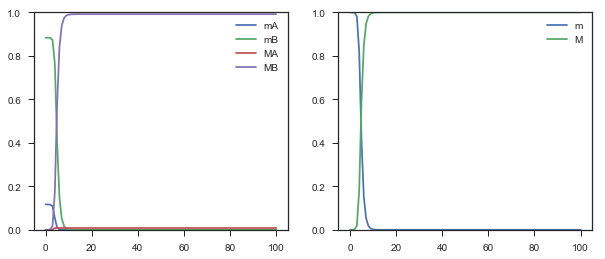

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(xs[:,0], label='mA')
axes[0].plot(xs[:,1], label='mB')
axes[0].plot(xs[:,2], label='MA')
axes[0].plot(xs[:,3], label='MB')
axes[0].legend()
axes[0].set_ylim(0, 1)

axes[1].plot(xs[:,0] + xs[:,1], label='m')
axes[1].plot(xs[:,2] + xs[:,3], label='M')
axes[1].legend()
axes[1].set_ylim(0, 1)

In [23]:
J = dF2(x, W, w, ρ, P, k, l, dx=1e-8)
print(J)
Lex = J[2:, 2:]
print(Lex)

[[  3.96512861e-01  -8.26757184e-02  -4.08222672e+01  -3.59611735e+00]
 [ -3.96519320e-01   8.26761235e-02  -5.38872954e+01  -4.13435361e+00]
 [  1.18186803e-07   9.61604369e-08   6.68695411e+00   5.45809010e-01]
 [  6.97737736e-06   1.35350615e-07   8.80226091e+01   7.18466258e+00]]
[[  6.68695411   0.54580901]
 [ 88.02260914   7.18466258]]


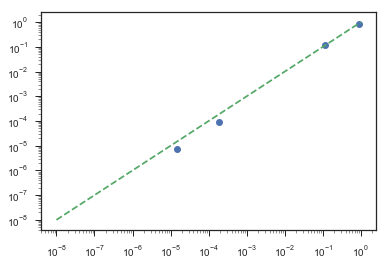

In [28]:
plt.plot(F2(x + 2*dx, W, w, ρ, P, k, l), x + J @ dx, 'o')
plt.yscale('log')
plt.xscale('log')
plt.plot(np.logspace(-8, 0), np.logspace(-8, 0), '--')

In [15]:
ρ, P, np.linalg.eigvals(Lex).max() > 1

(0.3, 0.7, True)

In [282]:
def external_stability_matrix(W, w, ρ, P, k, l, dx=1e-8):
    args1 = (W, w, ρ, k, l)
    args2 = (W, w, ρ, P, k, l)
    x1 = stablex1(*args1)
    if not np.allclose(x1, F1(x1, *args1)):
        warnings.warn("Stable x without M wasn't so stable: {}->{}".format(x1, F1(x1, *args1)))
    x = np.array([x1, 1-x1, 0.0, 0.0])
    if not np.allclose(x, F2(x, *args2)):
        warnings.warn("Stable x without M wasn't stable with M: {}->{}".format(x, F2(x, *args2)))
    J = dF2(x, *args2, dx=dx)
    L = J[2:,2:]
    return L
    
def λ1(W, w, ρ, P, k, l, dx=1e-8):
    # np.linalg.eigvals not supported by autograd, using formula
    # the standard formula losses precision, using non-standard
    # see: https://en.wikipedia.org/wiki/Loss_of_significance#Instability_of_the_quadratic_equation
    L = external_stability_matrix(W, w, ρ, P, k, l, dx=dx)
    # L = | L11 L12 |
    #     | L21 L22 |
    L11, L12, L21, L22 = L.ravel()
    # a = 1
    b = -(L11 + L22)
    c = L11 * L22 - L12 * L21
    D = np.sqrt(b**2 - 4*c)
    x1 = (-b - np.sign(b) * D) / 2
    assert np.isreal(x1), x1
    x2 = c / x1
    assert np.isreal(x2), x2
    return np.maximum(x1, x2)
dλ1 = grad(λ1, 3)

Lex = external_stability_matrix(W, w, ρ, P, k, l, dx=1e-8)
np.isclose(λ1(W, w, ρ, P, k, l, dx=1e-8), np.linalg.eigvals(Lex).max())

True

In [26]:
from concurrent.futures import ProcessPoolExecutor as Executor
from concurrent.futures import wait

In [27]:
def vλ1(W, w, ρs, Ps, k, l):
    with Executor() as exe:
        futures = [[exe.submit(λ1, W, w, ρ, P, k, l) for P in Ps] for ρ in ρs]
    return np.array([[f.result() for f in fs] for fs in futures])

In [28]:
def vdλ1(W, w, ρs, Ps, k, l):
    return np.array([[dλ1(W, w, ρ, P, k, l) for P in Ps] for ρ in ρs])

In [29]:
def grad_ascent(W, w, k, l, ρ0=0.5, η=1e-2, 
                 η0=1e-4, η_factor=2, convergence_tol=1e-2, λ1_atol=1e-6):
    ρ = ρ0
    ρs = [-1, ρ]
    η_ = η
    while η > η0 and not np.isclose(ρs[-1], ρs[-2], atol=convergence_tol) and 0 < ρ < 1:
        P = ρ + η * dλ1(W, w, ρ, ρ, k, l)
        if λ1(W, w, ρ, P, k, l) > 1-λ1_atol:
            ρ = P
            ρs.append(ρ)
            η = η_
        else:
            η /= η_factor
    ρs.pop(0)
    if ρs[-1] < 0:
        ρs[-1] = 0
    elif ρs[-1] > 1:
        ρs[-1] = 1
    return ρs

In [ ]:
ρs = np.linspace(1e-8, 1-1e-8, 100)
Ps = np.linspace(1e-8, 1-1e-8, 101)

In [ ]:
W, w = 1, 0.1

$\eta$ requires adjusting depending on $w$ and $k,l$.

In [ ]:
k, l = 1, 1

In [ ]:
λs1 = vλ1(W, w, ρs, Ps, k, l)

In [ ]:
ps1 = grad_ascent(W, w, k, l, ρ0=0.5, η=0.1)

In [ ]:
k, l = 10, 10

In [ ]:
λs10 = vλ1(W, w, ρs, Ps, k, l)

In [ ]:
ps10 = grad_ascent(W, w, k, l, ρ0=0.5, η=0.01)

In [ ]:
k, l = 20, 20

In [ ]:
λs20 = vλ1(W, w, ρs, Ps, k, l)

In [ ]:
ps20 = grad_ascent(W, w, k, l, ρ0=0.5, η=0.01)

In [ ]:
k, l = 40, 40

In [ ]:
λs40 = vλ1(W, w, ρs, Ps, k, l)

In [ ]:
ps40 = grad_ascent(W, w, k, l, ρ0=0.5, η=0.01)

In [ ]:
np.savez_compressed('AkBk_stable_modifier_w_{}.npz'.format(w), 
                    Ps=Ps, ρs=ρs, λs1=λs1, λs10=λs10, λs20=λs20, λs40=λs40, 
                    ps1=ps1, ps10=ps10, ps20=ps20, ps40=ps40)

In [97]:
d = np.load('AkBk_stable_modifier_w_{}.npz'.format(w))
Ps=d['Ps']
ρs=d['ρs']
λs1=d['λs1']
λs10=d['λs10']
λs20=d['λs20']
λs40=d['λs40']
ps1=d['ps1']
ps10=d['ps10']
ps20=d['ps20']
ps40=d['ps40']

del d

In [30]:
from matplotlib_colorbar.colorbar import Colorbar

def stability_plot(Ps, ρs, λs, ps, ax=None, arrow_kws=None, bounds=None):
    if ax is None:
        _, ax = plt.subplots()
    if bounds is None: 
        d = min(1 - np.nanmin(λs), np.nanmax(λs) - 1)
        bounds = np.linspace(1-d, 1+d, 256)
    if arrow_kws is None: arrow_kws = dict()
    for k, v in dict(length_includes_head = True, head_width=0.015, color='k').items():
        if k not in arrow_kws: arrow_kws[k] = v
    norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=bounds.size)
    im = ax.pcolormesh(Ps, ρs, λs, cmap='PRGn', norm=norm, rasterized=True)
    colorbar = Colorbar(im, location='lower right', length_fraction=0.25, ticks=[1],
                        box_alpha=0.75, font_properties=dict(size='small'),)    
    ax.add_artist(colorbar)
    xlabel = ax.set_xlabel(r'Invader rate - $P$')
    ylabel = ax.set_ylabel(r'Resident rate - $\rho$')
    ax.plot(Ps, Ps, color='k', linestyle='--', linewidth=0.75)
    for p, P in zip(ps[:-1], ps[1:]):
        ax.arrow(p, p, P-p, 0, **arrow_kws)
        ax.arrow(P, p, 0, P-p, **arrow_kws)

In [31]:
def log_bounds(λs):
    # these bounds work well for w=0.5
    d = min(np.log(1 - np.nanmin(λs)), np.log(np.nanmax(λs) - 1)) 
    return np.linspace(1-d, 1+d, 256)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(8, 7.5), sharex=True, sharey=True)
axes = axes.ravel()

stability_plot(Ps, ρs, λs1, ps1, axes[0])
stability_plot(Ps, ρs, λs10, ps10, axes[1])
stability_plot(Ps, ρs, λs20, ps20, axes[2], bounds=np.linspace(0, 2, 256))
stability_plot(Ps, ρs, λs40, [], axes[3], bounds=np.linspace(0, 2, 256))

axes[0].set(title='k=l=1', xlabel='')
axes[1].set(title='k=l=10', xlabel='', ylabel='')
axes[2].set(title='k=l=20')
axes[3].set(title='k=l=40', ylabel='')

fig_panel_labels(axes, xcoord=0, ycoord=1.01)
fig.tight_layout(w_pad=2)
fname = '../figures/AkBk_stable_modifier_w_{}'.format(w)
print(fname)
fig.savefig(fname+'.pdf')#, **savefig_bbox(xlabel, ylabel))
fig.savefig(fname+'.png')#, **savefig_bbox(xlabel, ylabel))

In [32]:
# @numba.jit()
def sign_ascent(W, w, k, l, ρ0=0.5, η=1e-2, λ1_atol=1e-4, max_iters=None):
    if max_iters in None:
        max_iters = int(1/η)
    ρ = ρ0
    iters = 0
    while 0 < ρ < 1:
        P = ρ + η * np.sign(dλ1(W, w, ρ, ρ, k, l))
        if λ1(W, w, ρ, P, k, l) > 1-λ1_atol:
            ρ = P 
        else:
            # saddle point
            print('**', ρ, P, λ1(W, w, ρ, P, k, l))
            break
        iters += 1
        if iters > max_iters:
            print('** max iters reached')
            break
    ρ = np.minimum(ρ, 1)
    ρ = np.maximum(ρ, 0)
    return ρ

In [ ]:
w = 0.9
k = 20

In [ ]:
sign_ascent(W, w, k, k, ρ0=0.01)

In [ ]:
sign_ascent(W, w, k, k, ρ0=0.99)

In [703]:
from autograd import optimizers

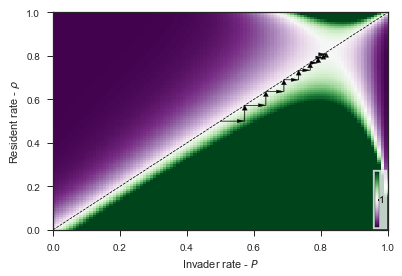

In [704]:
stability_plot(Ps, ρs, λs10, ps10)

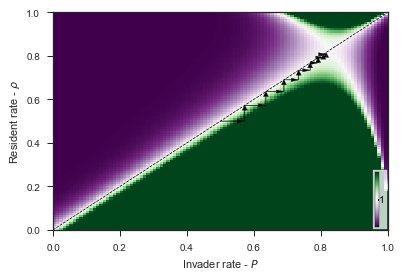

In [705]:
stability_plot(Ps, ρs, λs10**2, ps10)

In [360]:
def find_stable_rate(W, w, k, l):
    def λ1_(ρ, P):
        return λ1(W, w, ρ, P, k, l)
    dλ1dρ = grad(λ1_, 0)
    dλ1dP = grad(λ1_, 1)    
    def target(ρ):
        return dλ1dP(ρ, ρ)
    
    if target(0.0) * target(1-1e-5) < 0:    
        ρ, res = opt.brentq(target, 0.0, 1-1e-5, full_output=True)        
        if res.converged and np.isclose(target(ρ), 0):
            return ρ
    elif dλ1dP(0.0, 0.0) <= 0:
        return 0.0    
    return 1

In [280]:
W = 1.0
w = 0.1
ks = np.arange(1, 51, 1, dtype=int)
stable_rates = []

In [ ]:
for k in ks:
    stable_rates[k-1] = find_stable_rate(W, w, k, k)
stable_rates = np.array(stable_rates)

In [423]:
np.savez_compressed('stable_rates_w_{}.npz'.format(w), stable_rates=stable_rates, ks=ks)

In [426]:
ws = [0.1, 0.5, 0.9]
data = {}
for w in ws:
    data[str(w)] = np.load('stable_rates_w_{}.npz'.format(w))

/Users/yoavram/miniconda3/envs/Milpitas/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in true_divide


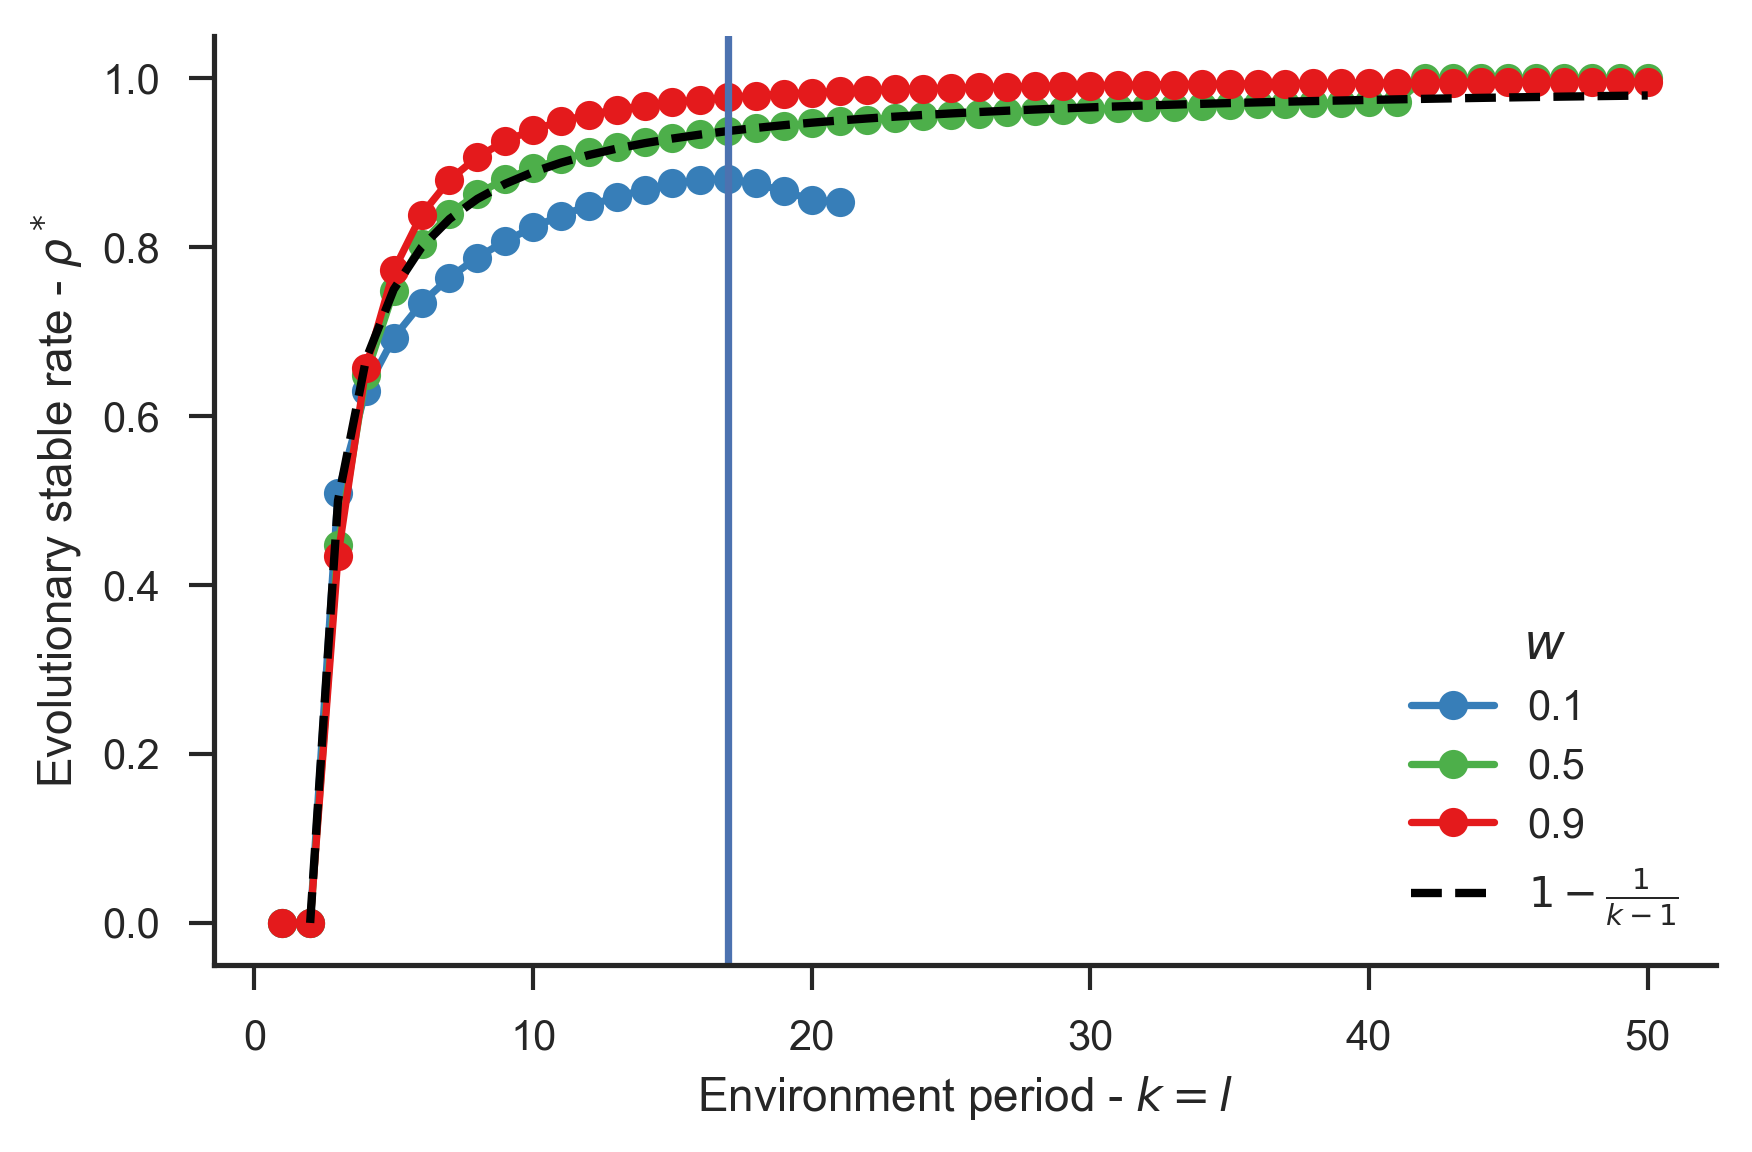

In [425]:
fig, ax = plt.subplots(dpi=300)

red, blue, green, purple, orange, yellow, brown, pink, gray = sns.color_palette("Set1", 9)


for w, c in zip(ws, [blue, green, red]):
    ks = data[str(w)]['ks']
    stable_rates = data[str(w)]['stable_rates']
    ax.plot(ks, stable_rates, 'o-', label=w, color=c)
ax.plot(ks, 1-1/(ks-1), lw=2, color='k', ls='--', label=r'$1-\frac{1}{k-1}$')

ax.set(
    xlabel=('Environment period - $k=l$'),
    ylabel=(r'Evolutionary stable rate - $\rho^*$'),
#     xlim=(1, 50),
#     xticks=[1, 10, 20, 30, 40, 50],
#     yticks=[0, 0.1, 0.2]
)
ax.legend(title='$w$', loc='lower right')
fig.tight_layout()
sns.despine()

ax.axvline(17)

In [428]:
import pandas as pd

In [433]:
df = []
for w in ws:
    for k, ρ in zip(data[str(w)]['ks'], data[str(w)]['stable_rates']):
        df.append(dict(k=k, ρ=ρ, w=w, l=k))
pd.DataFrame(df).to_csv('stable_rates_table.csv')

In [275]:
W, w, k, l = 1.0, 0.1, 15, 15
def λ1_(ρ, P):
    return λ1(W, w, ρ, P, k, l)
dλ1dρ = grad(λ1_, 0)
dλ1dP = grad(λ1_, 1)
def target(ρ):
    return dλ1dP(ρ, ρ)

In [488]:
find_stable_rate(1.0, 0.1, 30, 30)

1

In [489]:
W, w = 1.0, 0.1
k=l=30
def λ1_(ρ, P):
    return λ1(W, w, ρ, P, k, l)
dλ1dρ = grad(λ1_, 0)
dλ1dP = grad(λ1_, 1)    
def target(ρ):
    return dλ1dP(ρ, ρ)

ρ, res = opt.brentq(target, 0.0, 1-1e-5, full_output=True)   
res

      converged: True
           flag: 'converged'
 function_calls: 61
     iterations: 60
           root: 0.7850533517105183

In [446]:
import sys
sys.path.append('../src')
import geom

In [479]:
from geom2 import optimal_ρ

In [487]:
for w in [0.1, 0.5, 0.9]:
    print(w, optimal_ρ(w, 50, 50))

0.1 0.154190095878
0.5 0.221070050971
0.9 5.96086098655e-06
